# Import Libraries

In [1]:
import pandas as pd
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

/Users/hasanenesguray/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Upload Inputs

In [2]:
# Load the datasets
sales_data_path = 'Inputs/assignment4.1a.csv'
promotion_data_path = 'Inputs/PromotionDates.csv'
product_group_path = 'Inputs/assignment4.1c.csv'
test_sales_data_path = 'Inputs/assignment4.1b.csv'

# Reading the data from CSV files
sales_data = pd.read_csv(sales_data_path)
promotion_data = pd.read_csv(promotion_data_path)
product_group = pd.read_csv(product_group_path)
test_sales_data = pd.read_csv(test_sales_data_path)
promotion_data = promotion_data[0:4]
test_promotion_data = pd.read_csv(promotion_data_path)
test_promotion_data = test_promotion_data[4:]


# EDA

In [3]:
sales_data.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


In [4]:
promotion_data.head()

,Period,StartDate,EndDate
0,Promo1,2/10/2015,2/17/2015
1,Promo2,3/15/2015,3/22/2015
2,Promo3,5/24/2015,6/1/2015
3,Promo4,6/21/2015,6/28/2015


In [5]:
product_group.head()

,ProductCode,ProductGroup1,ProductGroup2
0,1,A,5
1,2,A,5
2,3,A,5
3,4,A,5
4,5,A,5


In [6]:
# Define a custom function to handle different date formats
def parse_date1(date_str):
    try:
        # Try parsing with a list of known formats
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except (ValueError, TypeError):
        try:
            return pd.to_datetime(date_str, format='%m/%d/%Y', errors='raise')
        except (ValueError, TypeError):
            try:
                # If all else fails, use dateutil.parser to infer format
                return parser.parse(date_str, dayfirst=False)
            except (ValueError, TypeError):
                return np.nan  # Return NaN if date can't be parsed

# Define a custom function to handle different date formats
def parse_date2(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y', errors='raise')
    except (ValueError, TypeError):
        try:
            # If all else fails, use dateutil.parser to infer format
            return parser.parse(date_str, dayfirst=False)
        except (ValueError, TypeError):
            return np.nan  # Return NaN if date can't be parsed

# Apply the custom function to the date columns in your data
sales_data['Date'] = sales_data['Date'].apply(parse_date1)
promotion_data['StartDate'] = promotion_data['StartDate'].apply(parse_date2)
promotion_data['EndDate'] = promotion_data['EndDate'].apply(parse_date2)

# Create a new column in sales_data to indicate whether each sale occurred during a promotion
sales_data['Promotion'] = 0

# Loop through each promotion period and flag the relevant sales
for _, promo in promotion_data.iterrows():
    sales_data.loc[(sales_data['Date'] >= promo['StartDate']) & (sales_data['Date'] <= promo['EndDate']), 'Promotion'] = 1

# Summarize the sales data by product and store, and whether a promotion was active
grouped_sales_data = sales_data.groupby(['StoreCode', 'ProductCode', 'Promotion'], as_index=False).agg({'SalesQuantity': 'sum'})

# Display the cleaned and summarized sales data
grouped_sales_data.head()

,StoreCode,ProductCode,Promotion,SalesQuantity
0,1,1,0,20
1,1,2,0,15
2,1,2,1,2
3,1,3,0,29
4,1,3,1,6


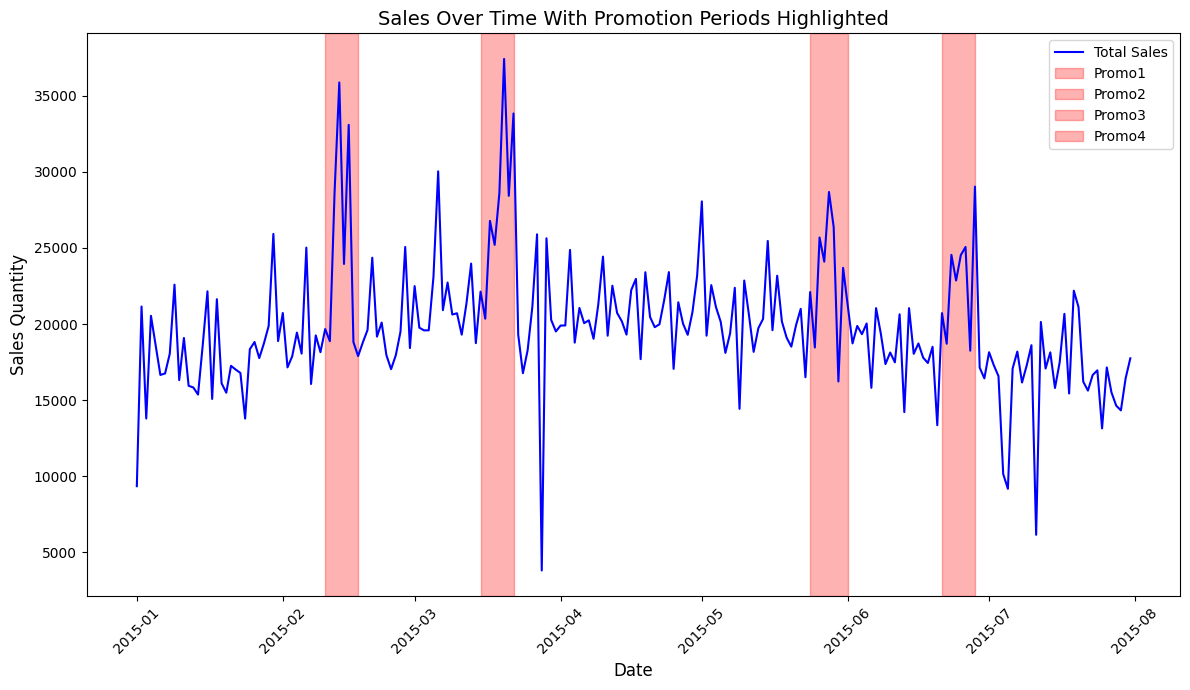

In [7]:
# Convert 'Date' column to datetime if not already done
sales_data['Date'] = pd.to_datetime(sales_data['Date'], errors='coerce')

# Group sales data by Date, summing the sales quantity
grouped_sales_data = sales_data.groupby(['Date']).agg({'SalesQuantity': 'sum'}).reset_index()

# Plotting the time series graph
plt.figure(figsize=(12, 7))

# Plot total sales over time
plt.plot(grouped_sales_data['Date'], grouped_sales_data['SalesQuantity'], label='Total Sales', color='blue')

# Add shaded areas for each promotion period
for _, promo in promotion_data.iterrows():
    plt.axvspan(promo['StartDate'], promo['EndDate'], color='red', alpha=0.3, label=promo['Period'])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Add title and labels
plt.title('Sales Over Time With Promotion Periods Highlighted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Quantity', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Step 3: Calculate total sales for each store and promotion status
grouped_sales = sales_data.groupby(['StoreCode', 'Promotion']).SalesQuantity.sum().unstack()

# Step 4: Calculate the total number of days in the dataset
total_days = (pd.to_datetime('2015-08-01') - pd.to_datetime('2015-01-01')).days + 1

# Step 5: Calculate the total number of promotion days from promotion_data
promotion_data['Duration(days)'] = (promotion_data['EndDate'] - promotion_data['StartDate']).dt.days + 1
total_promotion_days = promotion_data['Duration(days)'].sum()

# Calculate the total non-promotion days
total_non_promotion_days = total_days - total_promotion_days

# Step 6: Calculate average weekly sales during promotion and non-promotion periods
grouped_sales['No_Promotion_Avg_Weekly_Sales'] = (grouped_sales[0] / total_non_promotion_days) * 7
grouped_sales['Promotion_Avg_Weekly_Sales'] = (grouped_sales[1] / total_promotion_days) * 7
grouped_sales['Avg_Weekly_Sales'] = ((grouped_sales[1] + grouped_sales[0]) / total_days) * 7

# Step 7: Fill missing values with 0 if a store didn’t have sales during promotion or non-promotion
grouped_sales_store = grouped_sales.fillna(0)

# Step 8: Reset index to bring StoreCode back as a column
grouped_sales_store.reset_index(inplace=True)

# Display the result
print(grouped_sales_store[['StoreCode', 'No_Promotion_Avg_Weekly_Sales', 'Promotion_Avg_Weekly_Sales', 'Avg_Weekly_Sales']])


Promotion  StoreCode  No_Promotion_Avg_Weekly_Sales  \
0                  1                     403.433333   
1                  2                    1313.122222   
2                  3                     263.783333   
3                  4                     406.738889   
4                  5                     330.905556   
..               ...                            ...   
335              336                     343.622222   
336              337                     445.550000   
337              338                     374.616667   
338              339                     523.405556   
339              340                     620.122222   

Promotion  Promotion_Avg_Weekly_Sales  Avg_Weekly_Sales  
0                          468.363636        413.492958  
1                         1602.575758       1357.967136  
2                          327.727273        273.690141  
3                          626.393939        440.769953  
4                          407.909091        342.

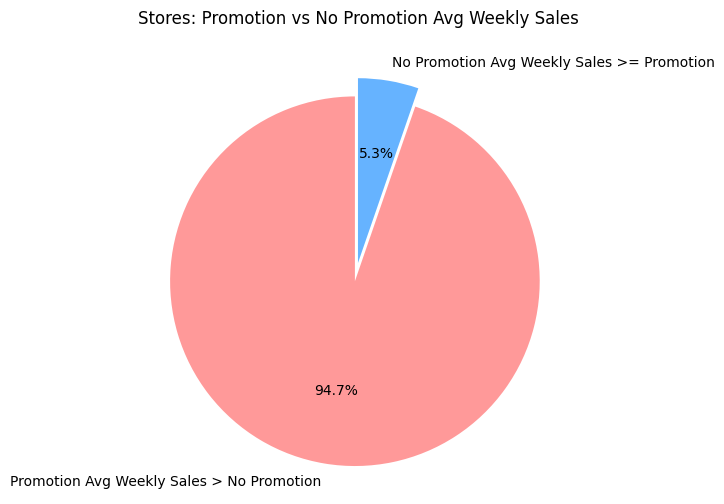

In [9]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
condition = grouped_sales_store['Promotion_Avg_Weekly_Sales'] > grouped_sales_store['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Stores: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

In [10]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Step 3: Calculate total sales for each product and promotion status
grouped_sales = sales_data.groupby(['ProductCode', 'Promotion']).SalesQuantity.sum().unstack()

# Step 4: Calculate the total number of days in the dataset
total_days = (pd.to_datetime('2015-08-01') - pd.to_datetime('2015-01-01')).days + 1

# Step 5: Calculate the total number of promotion days from promotion_data
promotion_data['Duration(days)'] = (promotion_data['EndDate'] - promotion_data['StartDate']).dt.days + 1
total_promotion_days = promotion_data['Duration(days)'].sum()

# Calculate the total non-promotion days
total_non_promotion_days = total_days - total_promotion_days

# Step 6: Calculate average weekly sales during promotion and non-promotion periods
grouped_sales['No_Promotion_Avg_Weekly_Sales'] = (grouped_sales[0] / total_non_promotion_days) * 7
grouped_sales['Promotion_Avg_Weekly_Sales'] = (grouped_sales[1] / total_promotion_days) * 7
grouped_sales['Avg_Weekly_Sales'] = ((grouped_sales[1] + grouped_sales[0]) / total_days) * 7

# Step 7: Fill missing values with 0 if a store didn’t have sales during promotion or non-promotion
grouped_sales_product = grouped_sales.fillna(0)

# Step 8: Reset index to bring StoreCode back as a column
grouped_sales_product.reset_index(inplace=True)

# Display the result
print(grouped_sales_product[['ProductCode', 'No_Promotion_Avg_Weekly_Sales', 'Promotion_Avg_Weekly_Sales', 'Avg_Weekly_Sales']])


Promotion  ProductCode  No_Promotion_Avg_Weekly_Sales  \
0                    1                     366.916667   
1                    2                     276.655556   
2                    3                     201.172222   
3                    4                     245.777778   
4                    5                     296.605556   
..                 ...                            ...   
312                313                     236.055556   
313                314                      26.094444   
314                315                      17.966667   
315                316                      37.877778   
316                317                      15.166667   

Promotion  Promotion_Avg_Weekly_Sales  Avg_Weekly_Sales  
0                          416.606061        374.615023  
1                          312.242424        282.169014  
2                          266.000000        211.215962  
3                          262.606061        248.384977  
4                        

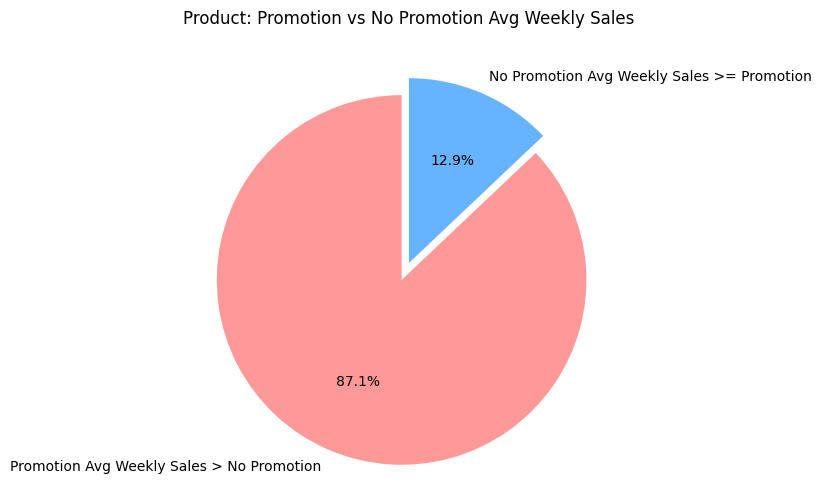

In [11]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
condition = grouped_sales_product['Promotion_Avg_Weekly_Sales'] > grouped_sales_product['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Product: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

In [12]:
sales_data

,Date,StoreCode,ProductCode,SalesQuantity,Promotion
0,2015-01-01,8,9,-1,0
1,2015-01-01,131,9,1,0
2,2015-01-01,144,9,2,0
3,2015-01-01,203,9,2,0
4,2015-01-01,256,9,0,0
...,...,...,...,...,...
1873613,2015-07-30,292,315,0,0
1873614,2015-07-31,12,315,1,0
1873615,2015-07-31,104,315,1,0
1873616,2015-07-31,261,315,1,0


# Model

## Product: Attempt 1

In [13]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

sales_data = sales_data.merge(product_group, on='ProductCode', how='left')

df_grouped = sales_data.groupby(['Week', 'ProductGroup1', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
df_grouped


,Week,ProductGroup1,Promotion,SalesQuantity
0,1,A,0,45004
1,1,B,0,750
2,1,C,0,2940
3,1,D,0,1439
4,1,E,0,1416
...,...,...,...,...
365,31,F,0,2218
366,31,G,0,16352
367,31,H,0,2467
368,31,I,0,1171


In [14]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
df_grouped = pd.get_dummies(df_grouped, columns=['ProductGroup1'], drop_first=True)

# Ensure all dummy variables (True/False) are converted to 1/0
df = df_grouped.astype(int)

# Check the data types of the columns
print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
X = df[['Promotion'] + [col for col in df.columns if col.startswith('ProductGroup1_')]]
y = df['SalesQuantity']

# Convert the target variable and feature matrix to numeric types (ensuring no objects)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_product = sm.OLS(y_train, X_train)
results_product = model_product.fit()

# Get the statistical summary of the model
print(results_product.summary())


Week               int64
Promotion          int64
SalesQuantity      int64
ProductGroup1_B    int64
ProductGroup1_C    int64
ProductGroup1_D    int64
ProductGroup1_E    int64
ProductGroup1_F    int64
ProductGroup1_G    int64
ProductGroup1_H    int64
ProductGroup1_I    int64
ProductGroup1_J    int64
dtype: object
                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     121.9
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           9.05e-97
Time:                        18:42:28   Log-Likelihood:                -3127.2
No. Observations:                 296   AIC:                             6276.
Df Residuals:                     285   BIC:                             6317.
Df Model:                          10                 

## Product: Attempt 2

In [15]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

df_grouped = sales_data.groupby(['Week', 'ProductGroup2', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
df_grouped


,Week,ProductGroup2,Promotion,SalesQuantity
0,1,1,0,749
1,1,2,0,137
2,1,3,0,1294
3,1,4,0,18103
4,1,5,0,39777
...,...,...,...,...
1088,31,26,0,2481
1089,31,27,0,255
1090,31,28,0,120
1091,31,29,0,1096


In [16]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
df_grouped = pd.get_dummies(df_grouped, columns=['ProductGroup2'], drop_first=True)

# Ensure all dummy variables (True/False) are converted to 1/0
df = df_grouped.astype(int)

# Check the data types of the columns
print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
X = df[['Promotion'] + [col for col in df.columns if col.startswith('ProductGroup2_')]]
y = df['SalesQuantity']

# Convert the target variable and feature matrix to numeric types (ensuring no objects)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_product = sm.OLS(y_train, X_train)
results_product = model_product.fit()

# Get the statistical summary of the model
print(results_product.summary())


Week                int64
Promotion           int64
SalesQuantity       int64
ProductGroup2_2     int64
ProductGroup2_3     int64
ProductGroup2_4     int64
ProductGroup2_5     int64
ProductGroup2_6     int64
ProductGroup2_7     int64
ProductGroup2_8     int64
ProductGroup2_9     int64
ProductGroup2_10    int64
ProductGroup2_11    int64
ProductGroup2_12    int64
ProductGroup2_13    int64
ProductGroup2_14    int64
ProductGroup2_15    int64
ProductGroup2_16    int64
ProductGroup2_17    int64
ProductGroup2_18    int64
ProductGroup2_19    int64
ProductGroup2_20    int64
ProductGroup2_21    int64
ProductGroup2_22    int64
ProductGroup2_23    int64
ProductGroup2_24    int64
ProductGroup2_25    int64
ProductGroup2_26    int64
ProductGroup2_27    int64
ProductGroup2_28    int64
ProductGroup2_29    int64
ProductGroup2_30    int64
dtype: object
                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.

## Product: Attempt 3

In [17]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

df_grouped = sales_data.groupby(['Week', 'ProductCode', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
df_grouped


,Week,ProductCode,Promotion,SalesQuantity
0,1,1,0,236
1,1,2,0,153
2,1,3,0,117
3,1,4,0,173
4,1,5,0,226
...,...,...,...,...
10476,31,313,0,220
10477,31,314,0,14
10478,31,315,0,15
10479,31,316,0,17


In [18]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
df_grouped = pd.get_dummies(df_grouped, columns=['ProductCode'], drop_first=True)

# Ensure all dummy variables (True/False) are converted to 1/0
df = df_grouped.astype(int)

# Check the data types of the columns
print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
X = df[['Promotion'] + [col for col in df.columns if col.startswith('ProductCode_')]]
y = df['SalesQuantity']

# Convert the target variable and feature matrix to numeric types (ensuring no objects)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_product = sm.OLS(y_train, X_train)
results_product = model_product.fit()

# Get the statistical summary of the model
print(results_product.summary())


Week               int64
Promotion          int64
SalesQuantity      int64
ProductCode_2      int64
ProductCode_3      int64
                   ...  
ProductCode_313    int64
ProductCode_314    int64
ProductCode_315    int64
ProductCode_316    int64
ProductCode_317    int64
Length: 319, dtype: object
                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     110.0
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:42:29   Log-Likelihood:                -63026.
No. Observations:                8384   AIC:                         1.267e+05
Df Residuals:                    8066   BIC:                         1.289e+05
Df Model:                         317                             

## Product: Attempt 4

In [19]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

df_grouped = sales_data.groupby(['Week', 'ProductCode', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
df_grouped


,Week,ProductCode,Promotion,SalesQuantity
0,1,1,0,236
1,1,2,0,153
2,1,3,0,117
3,1,4,0,173
4,1,5,0,226
...,...,...,...,...
10476,31,313,0,220
10477,31,314,0,14
10478,31,315,0,15
10479,31,316,0,17


In [20]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
df_grouped = pd.get_dummies(df_grouped, columns=['ProductCode'], drop_first=True)

# List of all possible ProductCode columns from ProductCode_2 to ProductCode_317
possible_product_columns = [f'ProductCode_{i}' for i in range(2, 318)]

# Ensure all missing ProductCode columns are added with default value 0
for col in possible_product_columns:
    if col not in df_grouped.columns:
        df_grouped[col] = 0

# Ensure all dummy variables (True/False) are converted to 1/0
df = df_grouped.astype(int)  # Apply to all columns, converting where necessary

# Check the data types of the columns
print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
X = df[['Promotion'] + possible_product_columns]  # Use the predefined list for ProductCode columns
y = df['SalesQuantity']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_product = sm.OLS(y_train, X_train)
results_product = model_product.fit()

# Get the statistical summary of the model
print(results_product.summary())

Week               int64
Promotion          int64
SalesQuantity      int64
ProductCode_2      int64
ProductCode_3      int64
                   ...  
ProductCode_313    int64
ProductCode_314    int64
ProductCode_315    int64
ProductCode_316    int64
ProductCode_317    int64
Length: 319, dtype: object
                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     110.0
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:42:29   Log-Likelihood:                -63026.
No. Observations:                8384   AIC:                         1.267e+05
Df Residuals:                    8066   BIC:                         1.289e+05
Df Model:                         317                             

In [21]:
# Define the custom start date
# start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
# sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

# df_grouped = sales_data
# df_grouped


In [22]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
# df_grouped = pd.get_dummies(df_grouped, columns=['ProductCode'], drop_first=True)

# Ensure all dummy variables (True/False) are converted to 1/0
# df = df_grouped.astype(int)

# Check the data types of the columns
# print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
# X = df[['Promotion'] + [col for col in df.columns if col.startswith('ProductCode_')]]
# y = df['SalesQuantity']

# Convert the target variable and feature matrix to numeric types (ensuring no objects)
# X = X.apply(pd.to_numeric, errors='coerce')
# y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
# X = sm.add_constant(X)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
# model = sm.OLS(y_train, X_train)
# results = model.fit()

# Get the statistical summary of the model
# print(results.summary())

## Store: Attempt 1

In [23]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')
    
# Create the 'Week' column based on the number of weeks since the start_date
sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

df_grouped = sales_data.groupby(['Week', 'StoreCode', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
df_grouped


,Week,StoreCode,Promotion,SalesQuantity
0,1,1,0,207
1,1,2,0,887
2,1,3,0,93
3,1,4,0,202
4,1,5,0,152
...,...,...,...,...
12234,31,336,0,156
12235,31,337,0,290
12236,31,338,0,150
12237,31,339,0,216


In [24]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
df_grouped = pd.get_dummies(df_grouped, columns=['StoreCode'], drop_first=True)

# Ensure all dummy variables (True/False) are converted to 1/0
df = df_grouped.astype(int)

# Check the data types of the columns
print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
X = df[['Promotion'] + [col for col in df.columns if col.startswith('StoreCode_')]]
y = df['SalesQuantity']

# Convert the target variable and feature matrix to numeric types (ensuring no objects)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_stores = sm.OLS(y_train, X_train)
results_stores = model_stores.fit()

# Get the statistical summary of the model
print(results_stores.summary())

Week             int64
Promotion        int64
SalesQuantity    int64
StoreCode_2      int64
StoreCode_3      int64
                 ...  
StoreCode_336    int64
StoreCode_337    int64
StoreCode_338    int64
StoreCode_339    int64
StoreCode_340    int64
Length: 342, dtype: object
                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     41.58
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:42:30   Log-Likelihood:                -64444.
No. Observations:                9791   AIC:                         1.296e+05
Df Residuals:                    9451   BIC:                         1.320e+05
Df Model:                         339                                         
Covarianc

## Store: Attempt 2

In [25]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

df_grouped = sales_data.groupby(['Week', 'StoreCode', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
df_grouped


,Week,StoreCode,Promotion,SalesQuantity
0,1,1,0,207
1,1,2,0,887
2,1,3,0,93
3,1,4,0,202
4,1,5,0,152
...,...,...,...,...
12234,31,336,0,156
12235,31,337,0,290
12236,31,338,0,150
12237,31,339,0,216


In [26]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
df_grouped = pd.get_dummies(df_grouped, columns=['StoreCode'], drop_first=True)

# List of all possible ProductCode columns from ProductCode_2 to ProductCode_317
possible_store_columns = [f'StoreCode_{i}' for i in range(2, 341)]

# Ensure all missing ProductCode columns are added with default value 0
for col in possible_store_columns:
    if col not in df_grouped.columns:
        df_grouped[col] = 0

# Ensure all dummy variables (True/False) are converted to 1/0
df = df_grouped.astype(int)  # Apply to all columns, converting where necessary

# Check the data types of the columns
print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
X = df[['Promotion'] + possible_store_columns]  # Use the predefined list for ProductCode columns
y = df['SalesQuantity']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_store = sm.OLS(y_train, X_train)
results_store = model_store.fit()

# Get the statistical summary of the model
print(results_store.summary())

Week             int64
Promotion        int64
SalesQuantity    int64
StoreCode_2      int64
StoreCode_3      int64
                 ...  
StoreCode_336    int64
StoreCode_337    int64
StoreCode_338    int64
StoreCode_339    int64
StoreCode_340    int64
Length: 342, dtype: object
                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     41.58
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:42:31   Log-Likelihood:                -64444.
No. Observations:                9791   AIC:                         1.296e+05
Df Residuals:                    9451   BIC:                         1.320e+05
Df Model:                         339                                         
Covarianc

In [27]:
# Define the custom start date
# start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
# sales_data['Week'] = ((sales_data['Date'] - start_date).dt.days // 7) + 1

# df_grouped = sales_data
# df_grouped


In [28]:
# Convert the ProductCode column to categorical variables using one-hot encoding, excluding the Week column
# df_grouped = pd.get_dummies(df_grouped, columns=['StoreCode'], drop_first=True)

# Ensure all dummy variables (True/False) are converted to 1/0
# df = df_grouped.astype(int)

# Check the data types of the columns
# print(df.dtypes)

# Define the feature matrix X and target variable y (excluding Week)
# X = df[['Promotion'] + [col for col in df.columns if col.startswith('StoreCode_')]]
# y = df['SalesQuantity']

# Convert the target variable and feature matrix to numeric types (ensuring no objects)
# X = X.apply(pd.to_numeric, errors='coerce')
# y = pd.to_numeric(y, errors='coerce')

# Add a constant to the model (for the intercept)
# X = sm.add_constant(X)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
# model = sm.OLS(y_train, X_train)
# results = model.fit()

# Get the statistical summary of the model
# print(results.summary())

# Clustering

In [29]:
# Define quantile-based categorization for stores based on "Avg_Weekly_Sales"
grouped_sales_store['Store_Cluster'] = pd.qcut(grouped_sales_store['No_Promotion_Avg_Weekly_Sales'], 
                                               q=3, 
                                               labels=['Slow stores', 'Medium stores', 'Fast stores'])

grouped_sales_store


Promotion,StoreCode,0,1,No_Promotion_Avg_Weekly_Sales,Promotion_Avg_Weekly_Sales,Avg_Weekly_Sales,Store_Cluster
0,1,10374.0,2208.0,403.433333,468.363636,413.492958,Fast stores
1,2,33766.0,7555.0,1313.122222,1602.575758,1357.967136,Fast stores
2,3,6783.0,1545.0,263.783333,327.727273,273.690141,Slow stores
3,4,10459.0,2953.0,406.738889,626.393939,440.769953,Fast stores
4,5,8509.0,1923.0,330.905556,407.909091,342.835681,Medium stores
...,...,...,...,...,...,...,...
335,336,8836.0,2157.0,343.622222,457.545455,361.272300,Medium stores
336,337,11457.0,2799.0,445.550000,593.727273,468.507042,Fast stores
337,338,9633.0,2245.0,374.616667,476.212121,390.356808,Medium stores
338,339,13459.0,3361.0,523.405556,712.939394,552.769953,Fast stores


In [30]:
# Define quantile-based categorization for products based on "No_Promotion_Avg_Weekly_Sales"
grouped_sales_product['Product_Cluster'] = pd.qcut(grouped_sales_product['No_Promotion_Avg_Weekly_Sales'], 
                                                 q=3, 
                                                 labels=['Slow items', 'Medium items', 'Fast items'])

grouped_sales_product


Promotion,ProductCode,0,1,No_Promotion_Avg_Weekly_Sales,Promotion_Avg_Weekly_Sales,Avg_Weekly_Sales,Product_Cluster
0,1,9435.0,1964.0,366.916667,416.606061,374.615023,Fast items
1,2,7114.0,1472.0,276.655556,312.242424,282.169014,Medium items
2,3,5173.0,1254.0,201.172222,266.000000,211.215962,Medium items
3,4,6320.0,1238.0,245.777778,262.606061,248.384977,Medium items
4,5,7627.0,1637.0,296.605556,347.242424,304.450704,Fast items
...,...,...,...,...,...,...,...
312,313,6070.0,1202.0,236.055556,254.969697,238.985915,Medium items
313,314,671.0,139.0,26.094444,29.484848,26.619718,Slow items
314,315,462.0,113.0,17.966667,23.969697,18.896714,Slow items
315,316,974.0,215.0,37.877778,45.606061,39.075117,Slow items


# Promotion Analysis

In [31]:
grouped_sales_store['Promotion_Effect'] = (grouped_sales_store['Promotion_Avg_Weekly_Sales'] / grouped_sales_store['No_Promotion_Avg_Weekly_Sales']) - 1
grouped_sales_store.sort_values(by='Promotion_Effect', ascending=False)


Promotion,StoreCode,0,1,No_Promotion_Avg_Weekly_Sales,Promotion_Avg_Weekly_Sales,Avg_Weekly_Sales,Store_Cluster,Promotion_Effect
91,92,2662.0,1114.0,103.522222,236.303030,124.093897,Slow stores,1.282631
163,164,2705.0,854.0,105.194444,181.151515,116.962441,Slow stores,0.722064
144,145,11872.0,3724.0,461.688889,789.939394,512.544601,Fast stores,0.710978
182,183,7593.0,2323.0,295.283333,492.757576,325.877934,Medium stores,0.668762
188,189,6670.0,2014.0,259.388889,427.212121,285.389671,Slow stores,0.646995
...,...,...,...,...,...,...,...,...
129,130,959.0,0.0,37.294444,0.000000,31.516432,Slow stores,-1.000000
18,19,0.0,0.0,0.000000,0.000000,0.000000,Slow stores,NaN
151,152,0.0,0.0,0.000000,0.000000,0.000000,Slow stores,NaN
168,169,0.0,0.0,0.000000,0.000000,0.000000,Slow stores,NaN


In [32]:
grouped_sales_product['Promotion_Effect'] = (grouped_sales_product['Promotion_Avg_Weekly_Sales'] / grouped_sales_product['No_Promotion_Avg_Weekly_Sales']) - 1
grouped_sales_product.sort_values(by='Promotion_Effect', ascending=False)


Promotion,ProductCode,0,1,No_Promotion_Avg_Weekly_Sales,Promotion_Avg_Weekly_Sales,Avg_Weekly_Sales,Product_Cluster,Promotion_Effect
290,291,3.0,3.0,0.116667,0.636364,0.197183,Slow items,4.454545
12,13,6.0,3.0,0.233333,0.636364,0.295775,Slow items,1.727273
228,229,17.0,7.0,0.661111,1.484848,0.788732,Slow items,1.245989
121,122,98.0,34.0,3.811111,7.212121,4.338028,Slow items,0.892393
65,66,241.0,82.0,9.372222,17.393939,10.615023,Slow items,0.855903
...,...,...,...,...,...,...,...,...
162,163,-1.0,2.0,-0.038889,0.424242,0.032864,Slow items,-11.909091
48,49,0.0,0.0,0.000000,0.000000,0.000000,Slow items,NaN
182,183,0.0,0.0,0.000000,0.000000,0.000000,Slow items,NaN
260,261,0.0,0.0,0.000000,0.000000,0.000000,Slow items,NaN


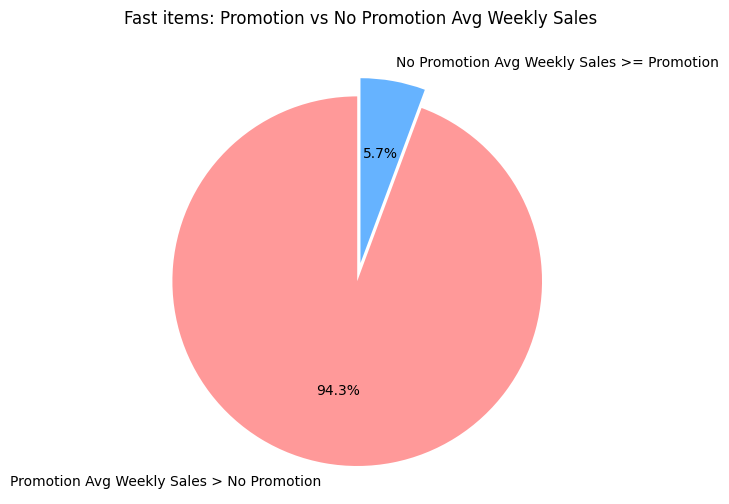

In [33]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
grouped_sales_product_fast = grouped_sales_product[grouped_sales_product['Product_Cluster'] == 'Fast items']
condition = grouped_sales_product_fast['Promotion_Avg_Weekly_Sales'] > grouped_sales_product_fast['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Fast items: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

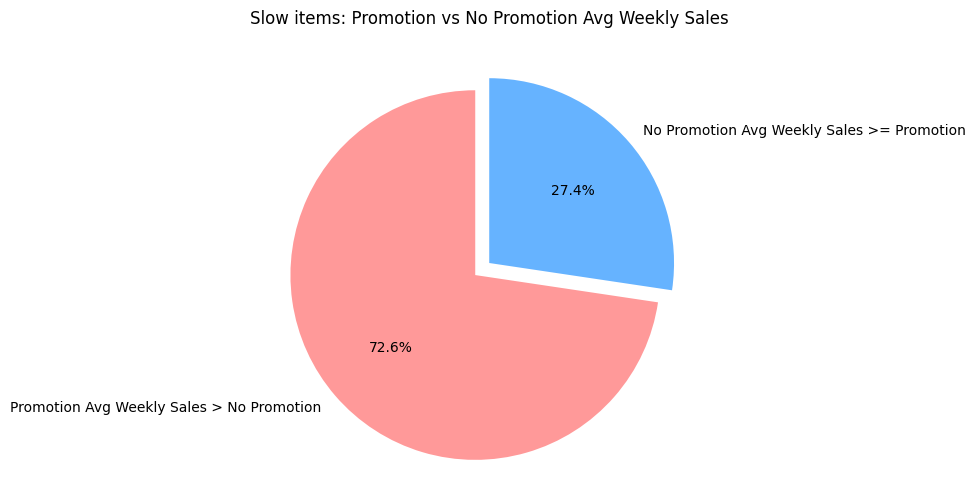

In [34]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
grouped_sales_product_slow = grouped_sales_product[grouped_sales_product['Product_Cluster'] == 'Slow items']
condition = grouped_sales_product_slow['Promotion_Avg_Weekly_Sales'] > grouped_sales_product_slow['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Slow items: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

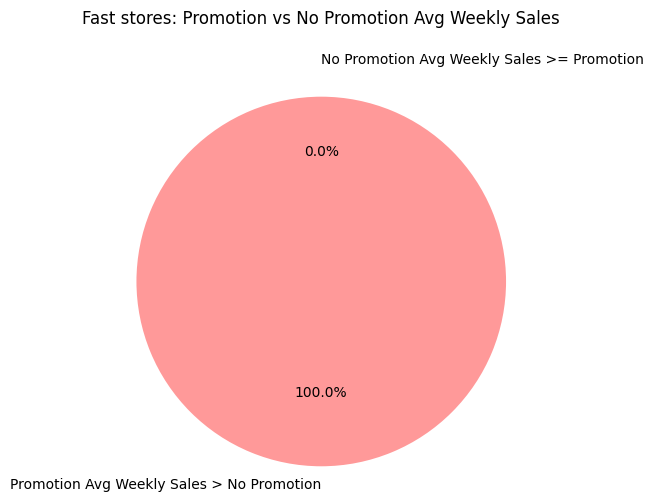

In [35]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
grouped_sales_store_fast = grouped_sales_store[grouped_sales_store['Store_Cluster'] == 'Fast stores']
condition = grouped_sales_store_fast['Promotion_Avg_Weekly_Sales'] > grouped_sales_store_fast['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Fast stores: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

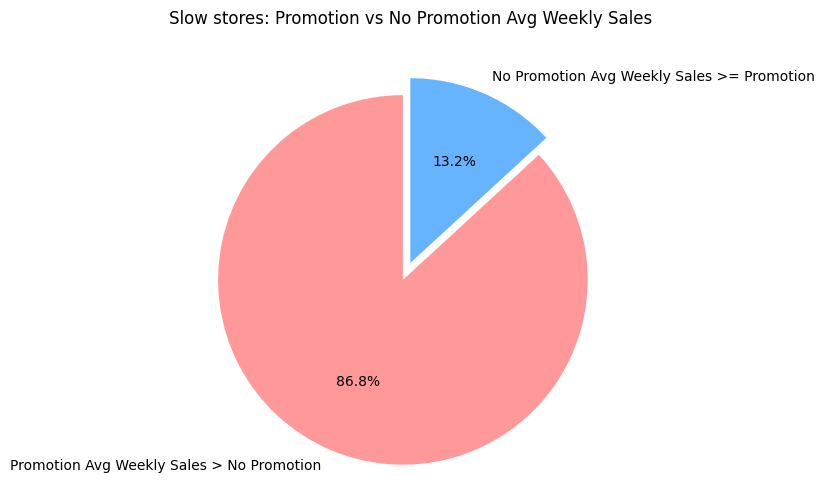

In [36]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
grouped_sales_store_slow = grouped_sales_store[grouped_sales_store['Store_Cluster'] == 'Slow stores']
condition = grouped_sales_store_slow['Promotion_Avg_Weekly_Sales'] > grouped_sales_store_slow['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Slow stores: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

# Test Model

In [37]:
test_sales_data.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-08-01,2,9,1
1,2015-08-01,7,9,1
2,2015-08-01,62,9,1
3,2015-08-01,181,9,1
4,2015-08-01,6,20,1


In [38]:
test_promotion_data.head()


,Period,StartDate,EndDate
4,Promo5,1/9/2015,6/9/2015
5,Promo6,20/11/2015,27/11/2015


In [39]:
# Apply the custom function to the date columns in your data
test_sales_data['Date'] = test_sales_data['Date'].apply(parse_date1)
test_promotion_data['StartDate'] = test_promotion_data['StartDate'].apply(parse_date1)
test_promotion_data['EndDate'] = test_promotion_data['EndDate'].apply(parse_date1)

# Create a new column in sales_data to indicate whether each sale occurred during a promotion
test_sales_data['Promotion'] = 0

# Loop through each promotion period and flag the relevant sales
for _, promo in test_promotion_data.iterrows():
    test_sales_data.loc[(test_sales_data['Date'] >= promo['StartDate']) & (test_sales_data['Date'] <= promo['EndDate']), 'Promotion'] = 1

# Summarize the sales data by product and store, and whether a promotion was active
grouped_test_sales_data = test_sales_data.groupby(['StoreCode', 'ProductCode', 'Promotion'], as_index=False).agg({'SalesQuantity': 'sum'})

# Display the cleaned and summarized sales data
grouped_test_sales_data.head()


,StoreCode,ProductCode,Promotion,SalesQuantity
0,1,1,0,5
1,1,1,1,2
2,1,2,0,3
3,1,2,1,1
4,1,4,0,1


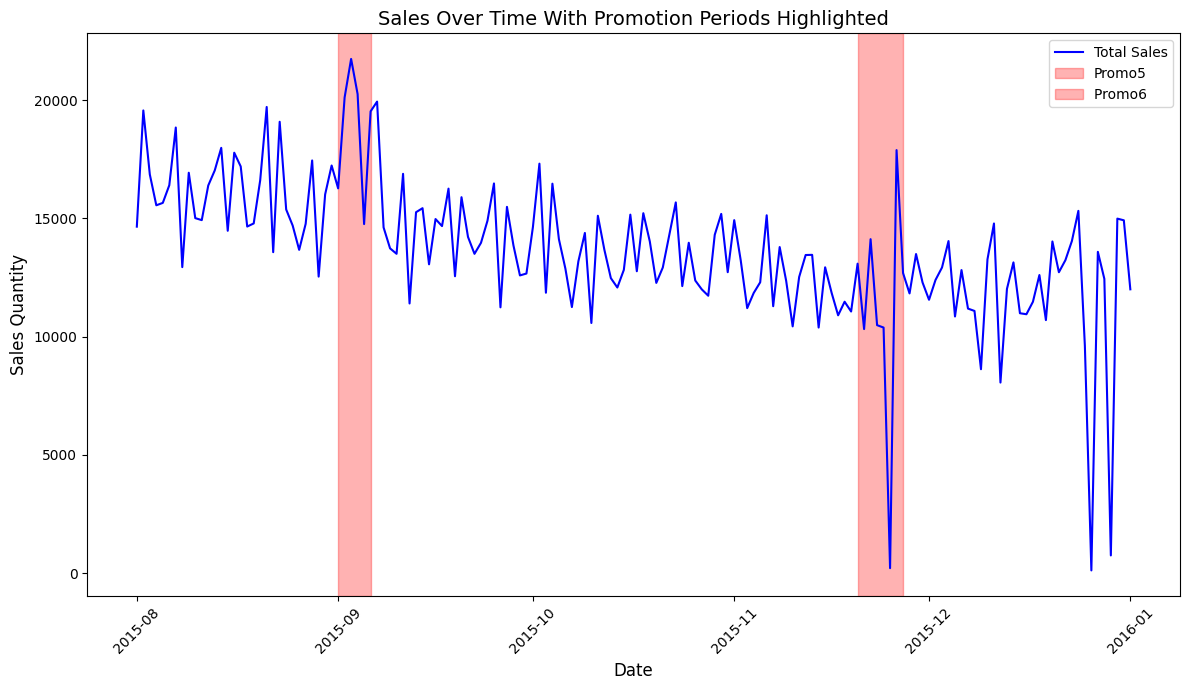

In [40]:
# Convert 'Date' column to datetime if not already done
test_sales_data['Date'] = pd.to_datetime(test_sales_data['Date'], errors='coerce')

# Group sales data by Date, summing the sales quantity
grouped_test_sales_data = test_sales_data.groupby(['Date']).agg({'SalesQuantity': 'sum'}).reset_index()

# Plotting the time series graph
plt.figure(figsize=(12, 7))

# Plot total sales over time
plt.plot(grouped_test_sales_data['Date'], grouped_test_sales_data['SalesQuantity'], label='Total Sales', color='blue')

# Add shaded areas for each promotion period
for _, promo in test_promotion_data.iterrows():
    plt.axvspan(promo['StartDate'], promo['EndDate'], color='red', alpha=0.3, label=promo['Period'])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Add title and labels
plt.title('Sales Over Time With Promotion Periods Highlighted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Quantity', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
test_sales_data['Date'] = pd.to_datetime(test_sales_data['Date'])

# Step 3: Calculate total sales for each store and promotion status
test_grouped_sales = test_sales_data.groupby(['StoreCode', 'Promotion']).SalesQuantity.sum().unstack()

# Step 4: Calculate the total number of days in the dataset
total_days = (pd.to_datetime('2015-08-01') - pd.to_datetime('2015-01-01')).days + 1

# Step 5: Calculate the total number of promotion days from promotion_data
test_promotion_data['Duration(days)'] = (test_promotion_data['EndDate'] - test_promotion_data['StartDate']).dt.days + 1
total_promotion_days = test_promotion_data['Duration(days)'].sum()

# Calculate the total non-promotion days
total_non_promotion_days = total_days - total_promotion_days

# Step 6: Calculate average weekly sales during promotion and non-promotion periods
test_grouped_sales['No_Promotion_Avg_Weekly_Sales'] = (test_grouped_sales[0] / total_non_promotion_days) * 7
test_grouped_sales['Promotion_Avg_Weekly_Sales'] = (test_grouped_sales[1] / total_promotion_days) * 7
test_grouped_sales['Avg_Weekly_Sales'] = ((test_grouped_sales[1] + test_grouped_sales[0]) / total_days) * 7

# Step 7: Fill missing values with 0 if a store didn’t have sales during promotion or non-promotion
test_grouped_sales_store = test_grouped_sales.fillna(0)

# Step 8: Reset index to bring StoreCode back as a column
test_grouped_sales_store.reset_index(inplace=True)

# Display the result
print(test_grouped_sales_store[['StoreCode', 'No_Promotion_Avg_Weekly_Sales', 'Promotion_Avg_Weekly_Sales', 'Avg_Weekly_Sales']])


Promotion  StoreCode  No_Promotion_Avg_Weekly_Sales  \
0                  1                     183.793970   
1                  2                     659.231156   
2                  3                     158.572864   
3                  4                     223.226131   
4                  5                     184.954774   
..               ...                            ...   
323              336                     182.527638   
324              337                     240.497487   
325              338                     236.592965   
326              339                      13.613065   
327              340                     350.211055   

Promotion  Promotion_Avg_Weekly_Sales  Avg_Weekly_Sales  
0                               338.0        193.929577  
1                               989.0        680.906103  
2                               265.5        165.600939  
3                               412.0        235.633803  
4                               375.0        197.

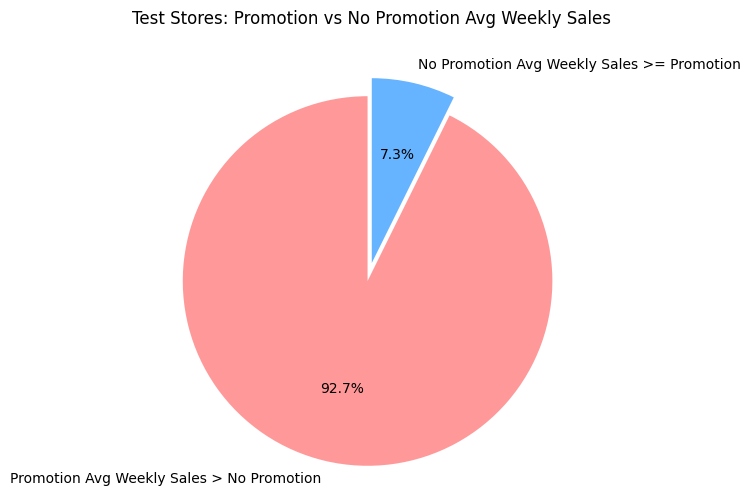

In [42]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
condition = test_grouped_sales_store['Promotion_Avg_Weekly_Sales'] > test_grouped_sales_store['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Test Stores: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

In [43]:
test_sales_data['Date'] = pd.to_datetime(test_sales_data['Date'])

# Step 3: Calculate total sales for each product and promotion status
test_grouped_sales = test_sales_data.groupby(['ProductCode', 'Promotion']).SalesQuantity.sum().unstack()

# Step 4: Calculate the total number of days in the dataset
total_days = (pd.to_datetime('2015-08-01') - pd.to_datetime('2015-01-01')).days + 1

# Step 5: Calculate the total number of promotion days from promotion_data
test_promotion_data['Duration(days)'] = (test_promotion_data['EndDate'] - test_promotion_data['StartDate']).dt.days + 1
total_promotion_days = test_promotion_data['Duration(days)'].sum()

# Calculate the total non-promotion days
total_non_promotion_days = total_days - total_promotion_days

# Step 6: Calculate average weekly sales during promotion and non-promotion periods
test_grouped_sales['No_Promotion_Avg_Weekly_Sales'] = (test_grouped_sales[0] / total_non_promotion_days) * 7
test_grouped_sales['Promotion_Avg_Weekly_Sales'] = (test_grouped_sales[1] / total_promotion_days) * 7
test_grouped_sales['Avg_Weekly_Sales'] = ((test_grouped_sales[1] + test_grouped_sales[0]) / total_days) * 7

# Step 7: Fill missing values with 0 if a store didn’t have sales during promotion or non-promotion
test_grouped_sales_product = test_grouped_sales.fillna(0)

# Step 8: Reset index to bring StoreCode back as a column
test_grouped_sales_product.reset_index(inplace=True)

# Display the result
print(test_grouped_sales_product[['ProductCode', 'No_Promotion_Avg_Weekly_Sales', 'Promotion_Avg_Weekly_Sales', 'Avg_Weekly_Sales']])


Promotion  ProductCode  No_Promotion_Avg_Weekly_Sales  \
0                    1                     225.160804   
1                    2                     170.356784   
2                    3                     129.025126   
3                    4                     158.432161   
4                    5                     169.477387   
..                 ...                            ...   
297                313                     419.753769   
298                314                       5.839196   
299                315                      11.748744   
300                316                      15.864322   
301                317                      11.115578   

Promotion  Promotion_Avg_Weekly_Sales  Avg_Weekly_Sales  
0                               338.5        232.610329  
1                               290.5        178.253521  
2                               126.5        128.859155  
3                               205.5        161.525822  
4                        

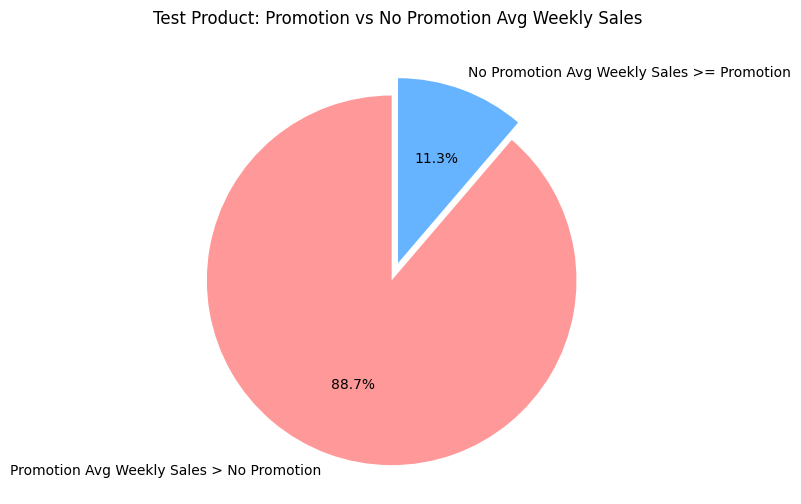

In [44]:
# Calculate the percentage of stores where Promotion_Avg_Sales is greater than No_Promotion_Avg_Sales
condition = test_grouped_sales_product['Promotion_Avg_Weekly_Sales'] > test_grouped_sales_product['No_Promotion_Avg_Weekly_Sales']
percent_promotion_better = condition.mean() * 100
percent_no_promotion_better = 100 - percent_promotion_better

# Pie chart labels and values
labels = ['Promotion Avg Weekly Sales > No Promotion', 'No Promotion Avg Weekly Sales >= Promotion']
sizes = [percent_promotion_better, percent_no_promotion_better]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0))
plt.title('Test Product: Promotion vs No Promotion Avg Weekly Sales')
plt.show()

In [45]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
test_sales_data['Week'] = ((test_sales_data['Date'] - start_date).dt.days // 7) + 1

test_df_grouped = test_sales_data.groupby(['Week', 'ProductCode', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
test_df_grouped


,Week,ProductCode,Promotion,SalesQuantity
0,31,1,0,138
1,31,2,0,97
2,31,3,0,78
3,31,4,0,74
4,31,5,0,125
...,...,...,...,...
7316,53,312,0,74
7317,53,313,0,240
7318,53,315,0,9
7319,53,316,0,12


In [46]:
# Convert the ProductCode column in test_df_grouped to categorical variables using one-hot encoding
test_df_grouped = pd.get_dummies(test_df_grouped, columns=['ProductCode'], drop_first=True)

# Ensure all missing ProductCode columns are added with default value 0 (for columns ProductCode_2 to ProductCode_317)
for col in possible_product_columns:
    if col not in test_df_grouped.columns:
        test_df_grouped[col] = 0

# Ensure all dummy variables (True/False) are converted to 1/0
test_df_grouped = test_df_grouped.astype(int)

# Define the feature matrix X_test_new (excluding Week and any other non-feature columns)
X_test_new = test_df_grouped[['Promotion'] + possible_product_columns]

# Ensure all columns are numeric
X_test_new = X_test_new.apply(pd.to_numeric, errors='coerce')

# Add a constant to the test set for the intercept (just like in the training set)
X_test_new = sm.add_constant(X_test_new)

# Use the trained model to predict sales quantities on the test data
y_pred_new = results_product.predict(X_test_new)

y_test = test_df_grouped['SalesQuantity']
y_test = pd.to_numeric(y_test, errors='coerce')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))

# Calculate R-squared
r2 = r2_score(y_test, y_pred_new)

# Print the results
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 491.2243005404243
R-squared: 0.45812144086468587


In [47]:
# Define the custom start date
start_date = pd.Timestamp('2014-12-30')

# Create the 'Week' column based on the number of weeks since the start_date
test_sales_data['Week'] = ((test_sales_data['Date'] - start_date).dt.days // 7) + 1

test_df_grouped = test_sales_data.groupby(['Week', 'StoreCode', 'Promotion']).agg({'SalesQuantity': 'sum'}).reset_index()
test_df_grouped


,Week,StoreCode,Promotion,SalesQuantity
0,31,1,0,261
1,31,2,0,324
2,31,3,0,141
3,31,4,0,94
4,31,5,0,190
...,...,...,...,...
8450,53,335,0,88
8451,53,336,0,164
8452,53,337,0,130
8453,53,338,0,200


In [48]:
# Convert the ProductCode column in test_df_grouped to categorical variables using one-hot encoding
test_df_grouped = pd.get_dummies(test_df_grouped, columns=['StoreCode'], drop_first=True)

# Ensure all missing ProductCode columns are added with default value 0 (for columns ProductCode_2 to ProductCode_317)
for col in possible_store_columns:
    if col not in test_df_grouped.columns:
        test_df_grouped[col] = 0

# Ensure all dummy variables (True/False) are converted to 1/0
test_df_grouped = test_df_grouped.astype(int)

# Define the feature matrix X_test_new (excluding Week and any other non-feature columns)
X_test_new = test_df_grouped[['Promotion'] + possible_store_columns]

# Ensure all columns are numeric
X_test_new = X_test_new.apply(pd.to_numeric, errors='coerce')

# Add a constant to the test set for the intercept (just like in the training set)
X_test_new = sm.add_constant(X_test_new)

# Use the trained model to predict sales quantities on the test data
y_pred_new = results_store.predict(X_test_new)

y_test = test_df_grouped['SalesQuantity']
y_test = pd.to_numeric(y_test, errors='coerce')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))

# Calculate R-squared
r2 = r2_score(y_test, y_pred_new)

# Print the results
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 172.88111434034312
R-squared: 0.21038521283561107


# Return Analysis

In [49]:
all_sales_data = pd.concat([sales_data, test_sales_data], ignore_index=True)
all_sales_data = all_sales_data[['Date', 'StoreCode', 'ProductCode', 'SalesQuantity', 'Promotion', 'Week']]
all_sales_data


,Date,StoreCode,ProductCode,SalesQuantity,Promotion,Week
0,2015-01-01,8,9,-1,0,1
1,2015-01-01,131,9,1,0,1
2,2015-01-01,144,9,2,0,1
3,2015-01-01,203,9,2,0,1
4,2015-01-01,256,9,0,0,1
...,...,...,...,...,...,...
2901734,2016-01-01,340,247,5,0,53
2901735,2016-01-01,340,264,1,0,53
2901736,2016-01-01,340,292,1,0,53
2901737,2016-01-01,340,305,1,0,53


In [50]:
return_data = all_sales_data[all_sales_data['SalesQuantity']<0]
return_data


,Date,StoreCode,ProductCode,SalesQuantity,Promotion,Week
0,2015-01-01,8,9,-1,0,1
159,2015-01-14,100,9,-1,0,3
353,2015-01-29,52,9,-1,0,5
912,2015-03-12,60,9,-1,0,11
936,2015-03-14,305,9,-1,0,11
...,...,...,...,...,...,...
2900463,2016-01-01,249,151,-1,0,53
2900889,2016-01-01,279,172,-4,0,53
2901202,2016-01-01,301,76,-1,0,53
2901211,2016-01-01,301,175,-1,0,53


In [51]:
all_promotion_data = pd.concat([promotion_data, test_promotion_data], ignore_index=True)
all_promotion_data


,Period,StartDate,EndDate,Duration(days)
0,Promo1,2015-02-10,2015-02-17,8
1,Promo2,2015-03-15,2015-03-22,8
2,Promo3,2015-05-24,2015-06-01,9
3,Promo4,2015-06-21,2015-06-28,8
4,Promo5,2015-09-01,2015-09-06,6
5,Promo6,2015-11-20,2015-11-27,8


/var/folders/_k/_rt6thqx6mj63rxtq_q_l7j00000gn/T/ipykernel_25735/1328491383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_data['Date'] = pd.to_datetime(return_data['Date'], errors='coerce')


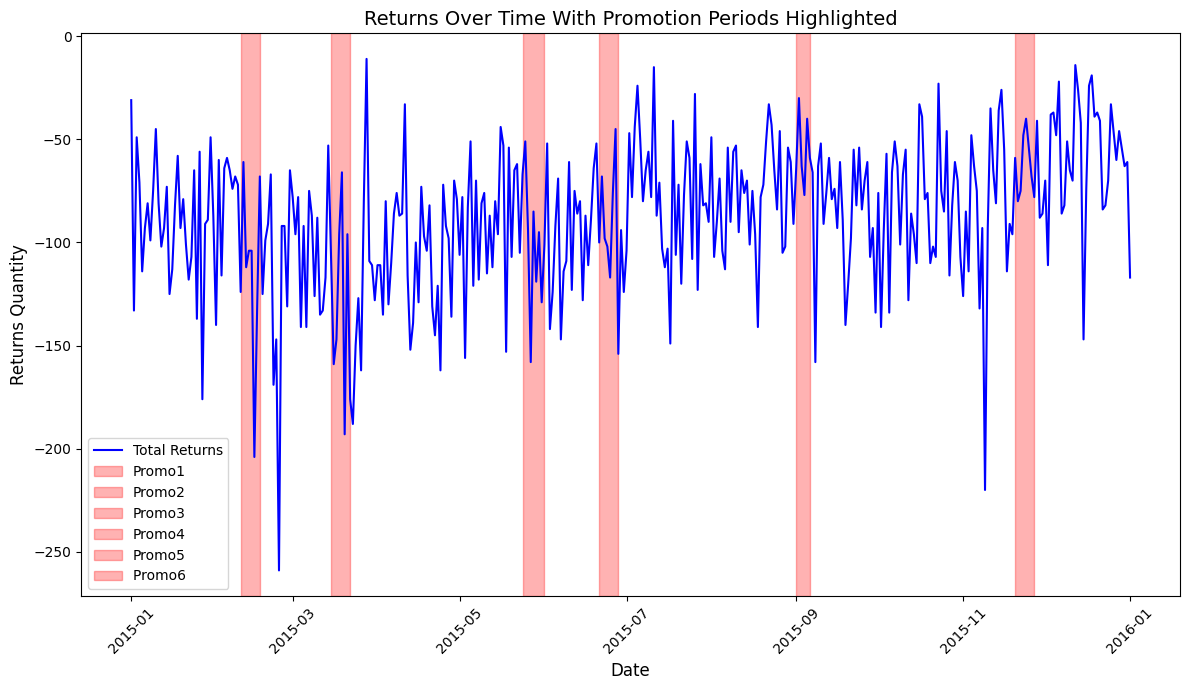

In [52]:
# Convert 'Date' column to datetime if not already done
return_data['Date'] = pd.to_datetime(return_data['Date'], errors='coerce')

# Group sales data by Date, summing the sales quantity
grouped_return_data = return_data.groupby(['Date']).agg({'SalesQuantity': 'sum'}).reset_index()

# Plotting the time series graph
plt.figure(figsize=(12, 7))

# Plot total sales over time
plt.plot(grouped_return_data['Date'], grouped_return_data['SalesQuantity'], label='Total Returns', color='blue')

# Add shaded areas for each promotion period
for _, promo in all_promotion_data.iterrows():
    plt.axvspan(promo['StartDate'], promo['EndDate'], color='red', alpha=0.3, label=promo['Period'])

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Add title and labels
plt.title('Returns Over Time With Promotion Periods Highlighted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns Quantity', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()